In [36]:
import torch

In [37]:
# Check device availability
device = ''
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
device = torch.device(device)
print("You are using device: %s" % device)

You are using device: mps


In [38]:
SAMPLE_DATA_FILE = 'data/sample.csv'
LABELS_OUTPUT = 'data/labels_multi_hot.pt'
W2V_EMBEDDED_VISIT_NOTES_OUTPUT = 'data/w2v_embedded_visit_notes.pt'
D2V_EMBEDDED_VISIT_NOTES_OUTPUT = 'data/d2v_embedded_visit_notes.pt'

In [39]:
import pandas as pd

# Printing raw data from data file
df = pd.read_csv(SAMPLE_DATA_FILE)
print(df)

       case_num  ...                                               text
0             0  ...  17-year-old male, has come to the student heal...
1             0  ...  17 yo male with recurrent palpitations for the...
2             0  ...  Dillon Cleveland is a 17 y.o. male patient wit...
3             0  ...  a 17 yo m c/o palpitation started 3 mos ago; \...
4             0  ...  17yo male with no pmh here for evaluation of p...
...         ...  ...                                                ...
42141         9  ...  Ms. Madden is a 20 yo female presenting w/ the...
42142         9  ...  A 20 YO F CAME COMPLAIN A DULL 8/10 HEADACHE T...
42143         9  ...  Ms. Madden is a 20yo female who presents with ...
42144         9  ...  Stephanie madden is a 20 year old woman compla...
42145         9  ...  patient is a 20 yo F who presents with a heada...

[42146 rows x 4 columns]


In [40]:
# Load embedded visit notes
d2v_embedded_visit_notes = torch.load(D2V_EMBEDDED_VISIT_NOTES_OUTPUT, weights_only=True)
w2v_embedded_visit_notes = torch.load(W2V_EMBEDDED_VISIT_NOTES_OUTPUT, weights_only=True)
labels = torch.load(LABELS_OUTPUT, weights_only=True)
print(d2v_embedded_visit_notes.shape)
print(w2v_embedded_visit_notes.shape)
print(labels.shape)

D2V_VECTOR_SIZE = d2v_embedded_visit_notes.shape[1]
W2V_VECTOR_SIZE = w2v_embedded_visit_notes.shape[1]

torch.Size([52722, 128])
torch.Size([52722, 100, 700])
torch.Size([52722, 6918])


In [41]:
embedded_visit_notes = [(d2v, w2v) for d2v, w2v in zip(d2v_embedded_visit_notes, w2v_embedded_visit_notes)]

In [42]:
import numpy as np
from torch.utils.data import DataLoader

from utils import ICD9_Dataset


percentage = 0.5
batch_size = 50

num_samples = int(np.floor(percentage * labels.shape[0]))
train_samples = int(np.floor(0.7 * num_samples))
leftovers = num_samples - train_samples
valid_samples = train_samples + int(np.floor(0.5*leftovers))

print("Total Samples: ", str(num_samples))
print("Train Samples: ", str(train_samples))
print("Valid Samples: ", str(valid_samples - train_samples))
print("Test Samples: ", str(num_samples - valid_samples))


# Initialize Dataset
train_dataset = ICD9_Dataset(embedded_visit_notes[:train_samples],
                              labels[:train_samples])
valid_dataset = ICD9_Dataset(embedded_visit_notes[train_samples:valid_samples],
                            labels[train_samples:valid_samples])
test_dataset = ICD9_Dataset(embedded_visit_notes[valid_samples:num_samples],
                              labels[valid_samples:num_samples])
# Initialize DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

Total Samples:  26361
Train Samples:  18452
Valid Samples:  3954
Test Samples:  3955


In [43]:
sample_set = embedded_visit_notes[0:5]
sample_set_d2v, sample_set_w2v = zip(*sample_set)
sample_set_d2v = torch.stack(sample_set_d2v)  
sample_set_w2v = torch.stack(sample_set_w2v)
print(sample_set_d2v.shape)
print(sample_set_w2v.shape)

torch.Size([5, 128])
torch.Size([5, 100, 700])


In [44]:
# Use CNN to process sample set of vector

import cnn 

my_cnn = cnn.CNN(device=device).to(device)

x = sample_set_w2v.to(device)
print(x.shape)

output = my_cnn.forward(x)
print(output.shape)


torch.Size([5, 100, 700])
torch.Size([5, 192])


In [45]:
# Use D2V Linear Layer to process sample set of vector

import importlib
import d2v_fc 

importlib.reload(d2v_fc)

dv2_model = d2v_fc.D2VFullyConnectedLayer(device=device).to(device)

x = sample_set_d2v.to(device)
print(x.shape)

output = dv2_model.forward(x)
print(output.shape)

torch.Size([5, 128])
torch.Size([5, 128])


In [46]:
# Use Combined Model to process sample set of data

import importlib
import icd9_dl_model 

importlib.reload(icd9_dl_model)
model = icd9_dl_model.ICD9DeepLearningModel(device=device, num_labels=labels.shape[1]).to(device)

x = (sample_set_d2v, sample_set_w2v)

output = model.forward(x)
print(output)

tensor([[ 0.5242,  0.2165,  1.1186,  ..., -0.3479,  0.2871, -0.0791],
        [ 0.6794, -0.1161, -1.0225,  ...,  0.2194,  1.0319, -0.2684],
        [ 0.1991,  0.1965,  0.1808,  ..., -0.0412,  0.1467, -0.3654],
        [ 0.6700, -0.7683, -0.0572,  ..., -0.2893,  0.2212, -0.0360],
        [ 1.2500, -0.1319, -0.0676,  ..., -0.0319,  1.3292, -0.5900]],
       device='mps:0', grad_fn=<LinearBackward0>)


In [25]:
from model_utils import train_model, evaluate
num_epochs = 10
# 10% data, 5 Epochs ~ 8.5 mins

model = icd9_dl_model.ICD9DeepLearningModel(device=device, num_labels=labels.shape[1]).to(device)

# weights_tensor = torch.tensor(weights, dtype=torch.float)
criterion = nn.CrossEntropyLoss() #pos_weight=weights_tensor
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


tlosses, tprecs, trecs, tf1s = [],[],[], []
vlosses, vprecs, vrecs, vf1s = [],[],[], []

best_val_f1 = 0.0

for epoch in range(num_epochs):
  tloss, tprec, trec, tf1 = train_model(model, train_loader, criterion, optimizer)
  vloss, vprec, vrec, vf1 = evaluate(model, valid_loader, criterion)

  tlosses.append(tloss)
  tprecs.append(tprec)
  trecs.append(trec)
  tf1s.append(tf1)

  vlosses.append(vloss)
  vrecs.append(vprec)
  vrecs.append(vrec)
  vf1s.append(vf1)

  is_best = vf1 > best_val_f1
  best_val_f1 = best_val_f1*(not is_best) + vf1*is_best

  # if is_best:
  #   best_val_f1 = vf1
    # torch.save(model, "myCNN.pth", _use_new_zipfile_serialization=False)

  print(f'Epoch {epoch+1}, Loss: {tlosses[-1]}, Valid F1: {vf1s[-1]}')

Epoch 1, Loss: 76.19542540472906, Valid F1: 0.08883630813072443
Epoch 2, Loss: 71.5974157333374, Valid F1: 0.08415944572324771
Epoch 3, Loss: 70.33401288212957, Valid F1: 0.08647966708139761
Epoch 4, Loss: 69.34125650766734, Valid F1: 0.0887012084057754
Epoch 5, Loss: 68.62714680852116, Valid F1: 0.09477824082609644
Epoch 6, Loss: 68.14380717921901, Valid F1: 0.09925090765990884
Epoch 7, Loss: 67.69967234843486, Valid F1: 0.10475661478603353
Epoch 8, Loss: 67.38134219195392, Valid F1: 0.10951216890475698
Epoch 9, Loss: 67.15256001240499, Valid F1: 0.11397743269281332
Epoch 10, Loss: 66.66445184656092, Valid F1: 0.12033218028846182


In [48]:
from utils import train, evaluate, plot_curves

def train_and_plot(model, optimizer, scheduler, criterion, train_loader, valid_loader, device, filename='', epochs=10, threshold=0.2):
    train_accuracies = []
    valid_accuracies = []
    train_losses = []
    valid_losses = []
    for epoch_idx in range(epochs):
        print("-----------------------------------")
        print("Epoch %d" % (epoch_idx+1))
        print("-----------------------------------")

        train_accuracy, train_loss, train_precision, train_recall, train_f1 = train(model, train_loader, criterion, optimizer, device=device, threshold=threshold)

        if scheduler:
            scheduler.step(train_loss)

        valid_accuracy, valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(model, valid_loader, criterion, device=device, threshold=threshold)

        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print("Training Loss: %.4f. Validation Loss: %.4f. " % (train_loss, valid_loss))
        print("Training Accuracy: %.4f. Validation Accuracy: %.4f. " % (train_accuracy, valid_accuracy))
        print("Training Precision: %.4f. Validation Precision: %.4f. " % (train_precision, valid_precision))
        print("Training Recall: %.4f. Validation Recall: %.4f. " % (train_recall, valid_recall))
        print("Training F1: %.4f. Validation F1: %.4f. " % (train_f1, valid_f1))

    plot_curves(train_accuracies, valid_accuracies, "Accuracy", filename, output_dir='outputs/')
    plot_curves(train_losses, valid_losses, "Loss", filename, output_dir='outputs/')

In [49]:
from utils import train, evaluate
import icd9_dl_model 

model = icd9_dl_model.ICD9DeepLearningModel(device=device, num_labels=labels.shape[1]).to(device)

train_accuracies = []
valid_accuracies = []
train_losses = []
valid_losses = []
epochs = 50
threshold = 0.4

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch_idx in range(epochs):
    print("-----------------------------------")
    print("Epoch %d" % (epoch_idx+1))
    print("-----------------------------------")

    train_accuracy, train_loss, train_precision, train_recall, train_f1 = train(model, train_loader, criterion, optimizer, device=device, threshold=threshold)

    # train_loss, train_precision, train_recall, train_f1 = train_model(model, train_loader, criterion, optimizer)
    # scheduler.step(train_loss)

    valid_accuracy, valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(model, valid_loader, criterion, device=device, threshold=threshold)
    # valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(model, valid_loader, criterion)

    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print("Training Loss: %.4f. Validation Loss: %.4f. " % (train_loss, valid_loss))
    print("Training Accuracy: %.4f. Validation Accuracy: %.4f. " % (train_accuracy, valid_accuracy))
    print("Training Precision: %.4f. Validation Precision: %.4f. " % (train_precision, valid_precision))
    print("Training Recall: %.4f. Validation Recall: %.4f. " % (train_recall, valid_recall))
    print("Training F1: %.4f. Validation F1: %.4f. " % (train_f1, valid_f1))

# plot_curves(train_accuracies, valid_accuracies, "Accuracy", filename, output_dir='outputs/')
# plot_curves(train_losses, valid_losses, "Loss", filename, output_dir='outputs/')

-----------------------------------
Epoch 1
-----------------------------------


Training:  54%|#####3    | 198/370 [00:12<00:10, 16.20it/s]

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/cs6250-finalproject/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/qx/27b52_vs16jbjnhkp1pr2f0m0000gn/T/ipykernel_30076/1910351327.py", line 22, in <module>
    train_accuracy, train_loss, train_precision, train_recall, train_f1 = train(model, train_loader, criterion, optimizer, device=device, threshold=threshold)
  File "/Users/parththakkar/Documents/ICD9_Deep_Learning/utils.py", line 91, in train
    metrics = score_model(y, outputs, threshold=threshold)
  File "/Users/parththakkar/Documents/ICD9_Deep_Learning/utils.py", line 29, in score_model
    preds[preds==1] != trues[preds==1]).sum()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/cs6250-finalproject/lib/python3.9/site-packages/IPython

-----------------------------------
Epoch 1
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 49.66it/s]


Training Loss: 78.3294. Validation Loss: 73.3516. 
Training Accuracy: 0.9505. Validation Accuracy: 0.9547. 
Training Precision: 0.0242. Validation Precision: 0.0279. 
Training Recall: 0.7056. Validation Recall: 0.7584. 
Training F1: 0.0467. Validation F1: 0.0538. 
-----------------------------------
Epoch 2
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 72.51it/s]


Training Loss: 73.0270. Validation Loss: 71.7477. 
Training Accuracy: 0.9486. Validation Accuracy: 0.9514. 
Training Precision: 0.0252. Validation Precision: 0.0273. 
Training Recall: 0.7731. Validation Recall: 0.7963. 
Training F1: 0.0487. Validation F1: 0.0528. 
-----------------------------------
Epoch 3
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 63.29it/s]


Training Loss: 71.6419. Validation Loss: 70.6879. 
Training Accuracy: 0.9437. Validation Accuracy: 0.9483. 
Training Precision: 0.0238. Validation Precision: 0.0263. 
Training Recall: 0.8018. Validation Recall: 0.8164. 
Training F1: 0.0463. Validation F1: 0.0509. 
-----------------------------------
Epoch 4
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:00<00:00, 81.68it/s]


Training Loss: 71.2356. Validation Loss: 69.9548. 
Training Accuracy: 0.9398. Validation Accuracy: 0.9467. 
Training Precision: 0.0227. Validation Precision: 0.0256. 
Training Recall: 0.8162. Validation Recall: 0.8256. 
Training F1: 0.0442. Validation F1: 0.0497. 
-----------------------------------
Epoch 5
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 66.23it/s]


Training Loss: 70.8206. Validation Loss: 70.7897. 
Training Accuracy: 0.9382. Validation Accuracy: 0.9453. 
Training Precision: 0.0223. Validation Precision: 0.0255. 
Training Recall: 0.8231. Validation Recall: 0.8323. 
Training F1: 0.0434. Validation F1: 0.0495. 
-----------------------------------
Epoch 6
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 79.28it/s]


Training Loss: 70.6015. Validation Loss: 69.8879. 
Training Accuracy: 0.9369. Validation Accuracy: 0.9450. 
Training Precision: 0.0220. Validation Precision: 0.0253. 
Training Recall: 0.8304. Validation Recall: 0.8371. 
Training F1: 0.0428. Validation F1: 0.0492. 
-----------------------------------
Epoch 7
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 47.66it/s]


Training Loss: 70.4885. Validation Loss: 70.0640. 
Training Accuracy: 0.9356. Validation Accuracy: 0.9448. 
Training Precision: 0.0216. Validation Precision: 0.0254. 
Training Recall: 0.8348. Validation Recall: 0.8398. 
Training F1: 0.0422. Validation F1: 0.0492. 
-----------------------------------
Epoch 8
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 59.02it/s]


Training Loss: 70.2480. Validation Loss: 70.3429. 
Training Accuracy: 0.9349. Validation Accuracy: 0.9444. 
Training Precision: 0.0215. Validation Precision: 0.0255. 
Training Recall: 0.8391. Validation Recall: 0.8441. 
Training F1: 0.0419. Validation F1: 0.0494. 
-----------------------------------
Epoch 9
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 79.62it/s]


Training Loss: 70.1610. Validation Loss: 70.2276. 
Training Accuracy: 0.9342. Validation Accuracy: 0.9436. 
Training Precision: 0.0213. Validation Precision: 0.0251. 
Training Recall: 0.8408. Validation Recall: 0.8454. 
Training F1: 0.0416. Validation F1: 0.0487. 
-----------------------------------
Epoch 10
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 57.61it/s]


Training Loss: 70.0717. Validation Loss: 69.9035. 
Training Accuracy: 0.9330. Validation Accuracy: 0.9440. 
Training Precision: 0.0211. Validation Precision: 0.0253. 
Training Recall: 0.8455. Validation Recall: 0.8463. 
Training F1: 0.0411. Validation F1: 0.0490. 


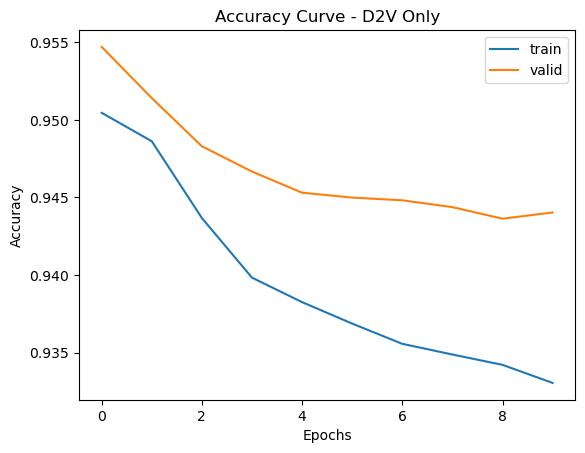

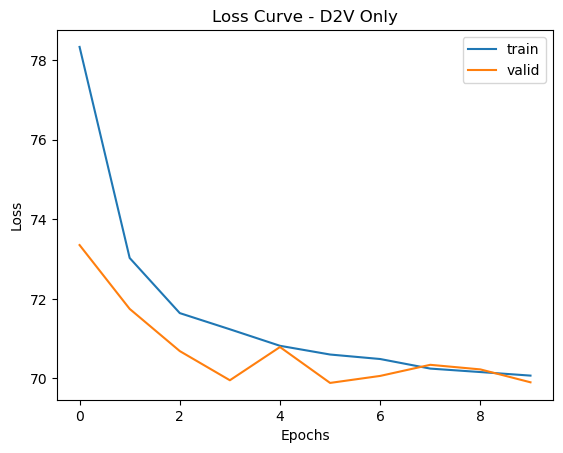

In [60]:
# D2V Only

import icd9_dl_model

learning_rate = 0.001
model = icd9_dl_model.ICD9DeepLearningModel(device=device, num_labels=labels.shape[1], specific_model="d2v").to(device)
scheduler = None #torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 10
file_name = "D2V Only"
threshold = 0.2

train_and_plot(model, optimizer, scheduler, criterion, train_loader, valid_loader, device, filename=file_name, threshold=0.2)

-----------------------------------
Epoch 1
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 33.64it/s]


Training Loss: 78.3733. Validation Loss: 74.3364. 
Training Accuracy: 0.9699. Validation Accuracy: 0.9789. 
Training Precision: 0.0385. Validation Precision: 0.0481. 
Training Recall: 0.5811. Validation Recall: 0.6077. 
Training F1: 0.0721. Validation F1: 0.0891. 
-----------------------------------
Epoch 2
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 43.88it/s]


Training Loss: 74.3759. Validation Loss: 72.5825. 
Training Accuracy: 0.9786. Validation Accuracy: 0.9813. 
Training Precision: 0.0477. Validation Precision: 0.0556. 
Training Recall: 0.6143. Validation Recall: 0.6303. 
Training F1: 0.0885. Validation F1: 0.1022. 
-----------------------------------
Epoch 3
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 44.45it/s]


Training Loss: 73.0129. Validation Loss: 71.5885. 
Training Accuracy: 0.9804. Validation Accuracy: 0.9826. 
Training Precision: 0.0532. Validation Precision: 0.0606. 
Training Recall: 0.6298. Validation Recall: 0.6393. 
Training F1: 0.0981. Validation F1: 0.1106. 
-----------------------------------
Epoch 4
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 39.19it/s]


Training Loss: 72.0474. Validation Loss: 70.6452. 
Training Accuracy: 0.9814. Validation Accuracy: 0.9840. 
Training Precision: 0.0569. Validation Precision: 0.0666. 
Training Recall: 0.6392. Validation Recall: 0.6473. 
Training F1: 0.1044. Validation F1: 0.1208. 
-----------------------------------
Epoch 5
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 40.23it/s]


Training Loss: 71.2081. Validation Loss: 70.7249. 
Training Accuracy: 0.9826. Validation Accuracy: 0.9853. 
Training Precision: 0.0607. Validation Precision: 0.0721. 
Training Recall: 0.6415. Validation Recall: 0.6425. 
Training F1: 0.1109. Validation F1: 0.1295. 
-----------------------------------
Epoch 6
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 38.57it/s]


Training Loss: 70.7133. Validation Loss: 69.7601. 
Training Accuracy: 0.9834. Validation Accuracy: 0.9861. 
Training Precision: 0.0634. Validation Precision: 0.0751. 
Training Recall: 0.6412. Validation Recall: 0.6376. 
Training F1: 0.1153. Validation F1: 0.1343. 
-----------------------------------
Epoch 7
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 42.32it/s]


Training Loss: 70.2213. Validation Loss: 69.5775. 
Training Accuracy: 0.9842. Validation Accuracy: 0.9869. 
Training Precision: 0.0662. Validation Precision: 0.0794. 
Training Recall: 0.6370. Validation Recall: 0.6336. 
Training F1: 0.1199. Validation F1: 0.1410. 
-----------------------------------
Epoch 8
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 32.33it/s]


Training Loss: 69.7804. Validation Loss: 69.2111. 
Training Accuracy: 0.9849. Validation Accuracy: 0.9875. 
Training Precision: 0.0689. Validation Precision: 0.0824. 
Training Recall: 0.6313. Validation Recall: 0.6302. 
Training F1: 0.1242. Validation F1: 0.1457. 
-----------------------------------
Epoch 9
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 29.78it/s]


Training Loss: 69.3544. Validation Loss: 69.3920. 
Training Accuracy: 0.9855. Validation Accuracy: 0.9881. 
Training Precision: 0.0714. Validation Precision: 0.0860. 
Training Recall: 0.6288. Validation Recall: 0.6207. 
Training F1: 0.1281. Validation F1: 0.1510. 
-----------------------------------
Epoch 10
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 38.70it/s]

Training Loss: 69.0032. Validation Loss: 69.3348. 
Training Accuracy: 0.9862. Validation Accuracy: 0.9890. 
Training Precision: 0.0741. Validation Precision: 0.0910. 
Training Recall: 0.6208. Validation Recall: 0.6082. 
Training F1: 0.1323. Validation F1: 0.1581. 


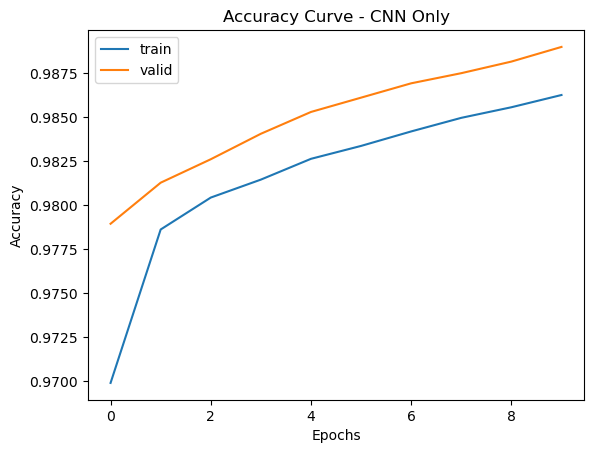

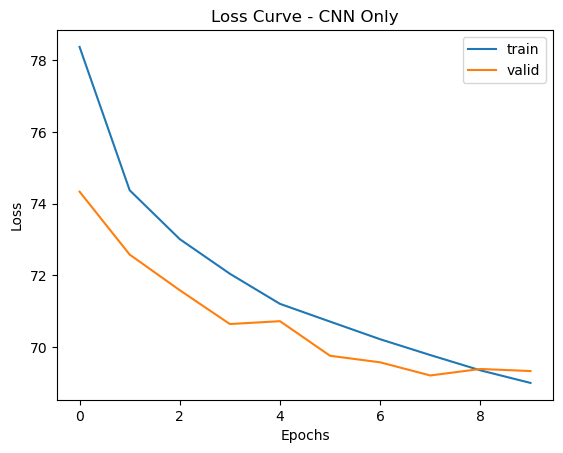

In [61]:
# CNN Only

import icd9_dl_model 

learning_rate = 0.001
model = icd9_dl_model.ICD9DeepLearningModel(device=device, num_labels=labels.shape[1], specific_model="cnn").to(device)
scheduler = None #torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 10
file_name = "CNN Only"
threshold = 0.2

train_and_plot(model, optimizer, scheduler, criterion, train_loader, valid_loader, device, filename=file_name, threshold=0.2)

-----------------------------------
Epoch 1
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 44.67it/s]


Training Loss: 76.2625. Validation Loss: 72.1017. 
Training Accuracy: 0.9706. Validation Accuracy: 0.9745. 
Training Precision: 0.0395. Validation Precision: 0.0451. 
Training Recall: 0.6234. Validation Recall: 0.6916. 
Training F1: 0.0742. Validation F1: 0.0846. 
-----------------------------------
Epoch 2
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 41.11it/s]


Training Loss: 71.6951. Validation Loss: 70.3095. 
Training Accuracy: 0.9687. Validation Accuracy: 0.9715. 
Training Precision: 0.0376. Validation Precision: 0.0427. 
Training Recall: 0.7050. Validation Recall: 0.7364. 
Training F1: 0.0713. Validation F1: 0.0807. 
-----------------------------------
Epoch 3
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 38.28it/s]


Training Loss: 70.3287. Validation Loss: 69.7753. 
Training Accuracy: 0.9653. Validation Accuracy: 0.9704. 
Training Precision: 0.0356. Validation Precision: 0.0424. 
Training Recall: 0.7440. Validation Recall: 0.7550. 
Training F1: 0.0679. Validation F1: 0.0802. 
-----------------------------------
Epoch 4
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 43.27it/s]


Training Loss: 69.3573. Validation Loss: 68.5144. 
Training Accuracy: 0.9646. Validation Accuracy: 0.9716. 
Training Precision: 0.0356. Validation Precision: 0.0442. 
Training Recall: 0.7585. Validation Recall: 0.7617. 
Training F1: 0.0680. Validation F1: 0.0835. 
-----------------------------------
Epoch 5
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 40.93it/s]


Training Loss: 68.8726. Validation Loss: 68.3727. 
Training Accuracy: 0.9657. Validation Accuracy: 0.9734. 
Training Precision: 0.0369. Validation Precision: 0.0472. 
Training Recall: 0.7626. Validation Recall: 0.7587. 
Training F1: 0.0704. Validation F1: 0.0888. 
-----------------------------------
Epoch 6
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 37.27it/s]


Training Loss: 68.2791. Validation Loss: 67.6034. 
Training Accuracy: 0.9674. Validation Accuracy: 0.9743. 
Training Precision: 0.0386. Validation Precision: 0.0484. 
Training Recall: 0.7599. Validation Recall: 0.7574. 
Training F1: 0.0735. Validation F1: 0.0910. 
-----------------------------------
Epoch 7
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 35.97it/s]


Training Loss: 67.7025. Validation Loss: 67.4933. 
Training Accuracy: 0.9688. Validation Accuracy: 0.9766. 
Training Precision: 0.0404. Validation Precision: 0.0523. 
Training Recall: 0.7597. Validation Recall: 0.7463. 
Training F1: 0.0766. Validation F1: 0.0977. 
-----------------------------------
Epoch 8
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 44.62it/s]


Training Loss: 67.3954. Validation Loss: 67.5985. 
Training Accuracy: 0.9701. Validation Accuracy: 0.9777. 
Training Precision: 0.0417. Validation Precision: 0.0544. 
Training Recall: 0.7531. Validation Recall: 0.7369. 
Training F1: 0.0790. Validation F1: 0.1013. 
-----------------------------------
Epoch 9
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 40.92it/s]


Training Loss: 67.0181. Validation Loss: 66.9003. 
Training Accuracy: 0.9715. Validation Accuracy: 0.9789. 
Training Precision: 0.0436. Validation Precision: 0.0567. 
Training Recall: 0.7482. Validation Recall: 0.7334. 
Training F1: 0.0823. Validation F1: 0.1052. 
-----------------------------------
Epoch 10
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 42.40it/s]


Training Loss: 66.9624. Validation Loss: 66.9192. 
Training Accuracy: 0.9732. Validation Accuracy: 0.9800. 
Training Precision: 0.0458. Validation Precision: 0.0592. 
Training Recall: 0.7388. Validation Recall: 0.7257. 
Training F1: 0.0861. Validation F1: 0.1093. 


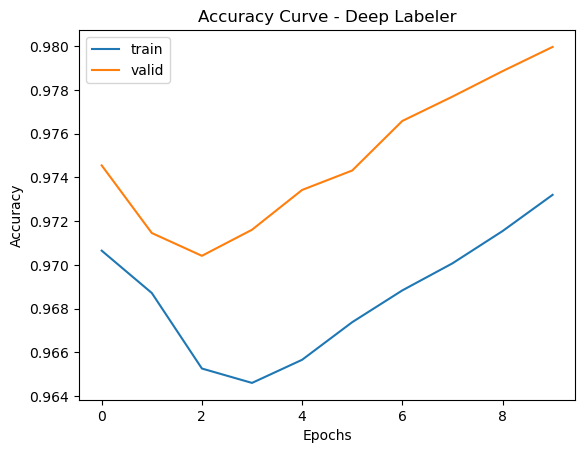

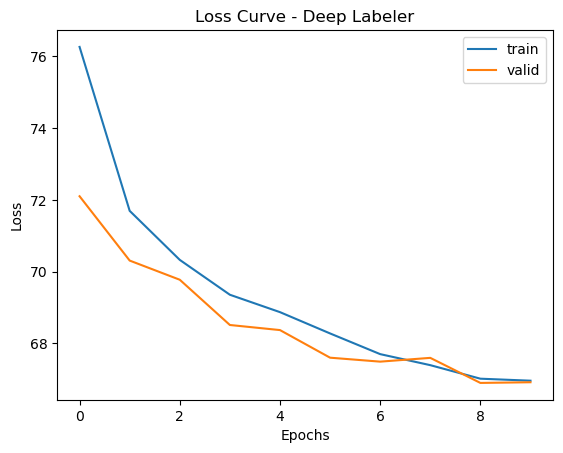

In [62]:
# Combined Deep Labeler

import icd9_dl_model 

learning_rate = 0.001
model = icd9_dl_model.ICD9DeepLearningModel(device=device, num_labels=labels.shape[1]).to(device)
scheduler = None #torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 10
file_name = "Deep Labeler"
threshold = 0.2

train_and_plot(model, optimizer, scheduler, criterion, train_loader, valid_loader, device, filename=file_name, threshold=0.2)